In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv,rgba2rgb
from skimage.measure import label

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median , gaussian
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Exposure
from skimage.exposure import equalize_adapthist, equalize_hist

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

#Morphology:
from skimage.morphology import dilation, erosion, opening, closing,rectangle,isotropic_opening,isotropic_closing, binary_dilation, binary_erosion


# Hough Transform
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import line as draw_line
from skimage import data

# OpenCv
import imutils  
import cv2


from itertools import combinations

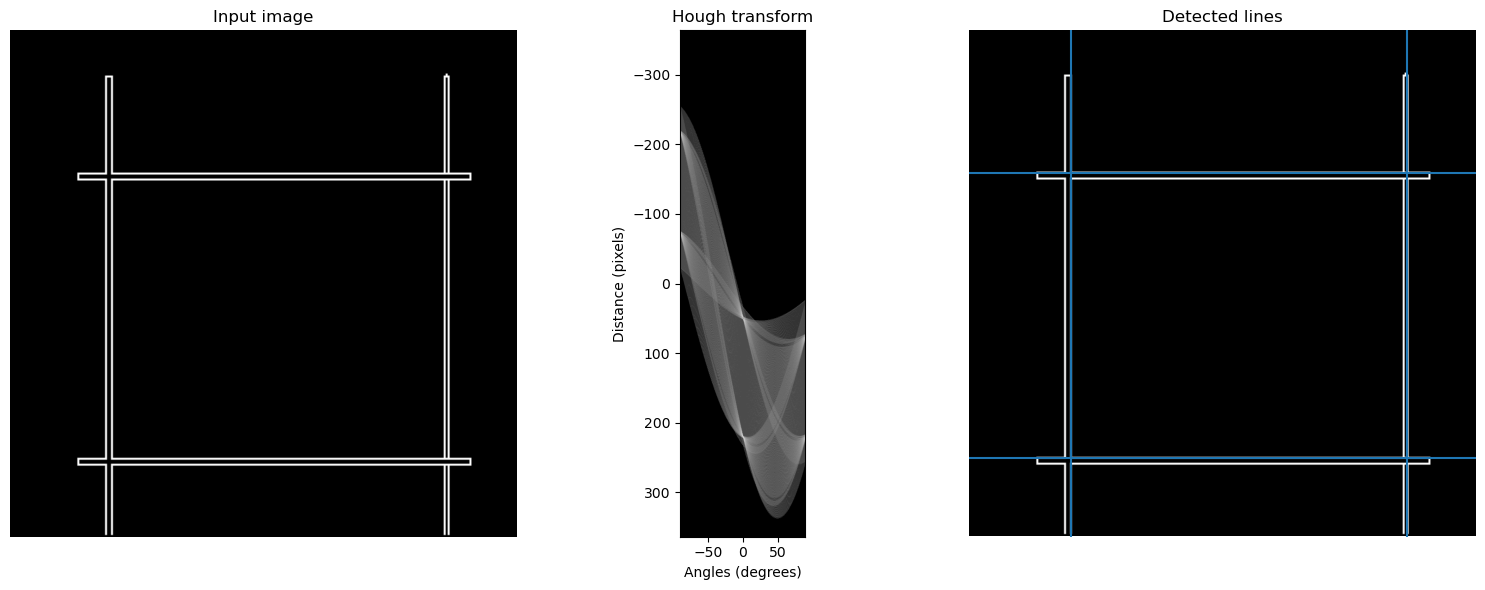

[(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]
72 216
51 221


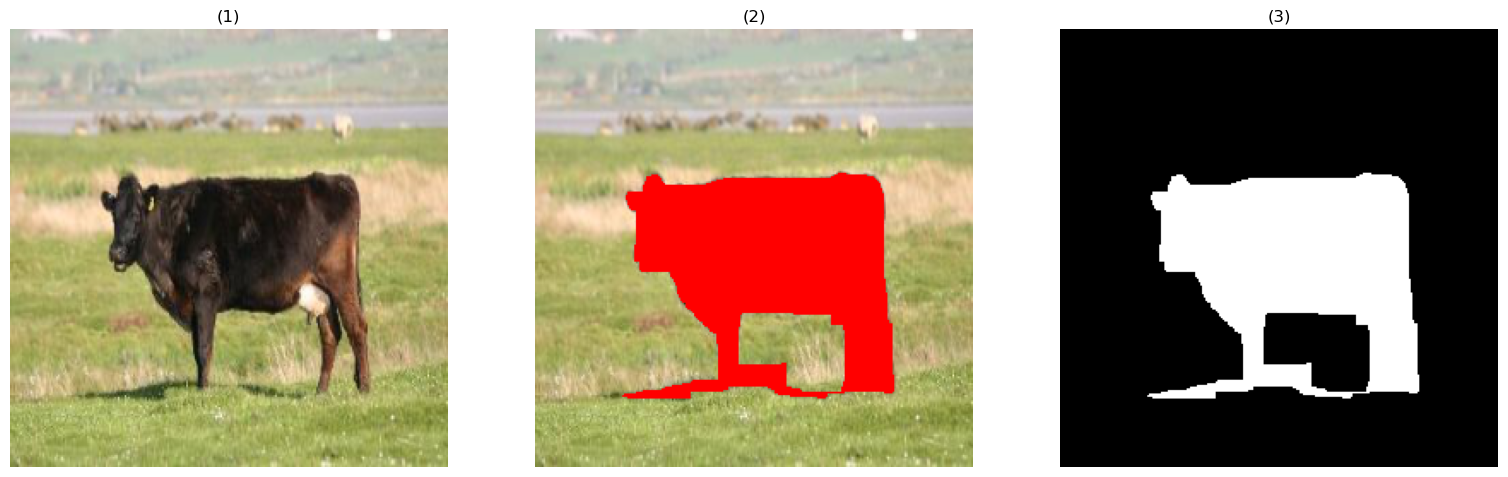

[[[180 193 176]
  [181 194 177]
  [182 194 177]
  ...
  [192 178 169]
  [188 174 165]
  [185 171 162]]

 [[181 194 177]
  [182 195 178]
  [184 195 179]
  ...
  [195 181 172]
  [191 177 168]
  [189 175 167]]

 [[183 195 178]
  [183 195 179]
  [186 196 180]
  ...
  [194 182 173]
  [192 181 171]
  [192 180 170]]

 ...

 [[134 145  68]
  [136 146  72]
  [130 139  72]
  ...
  [163 174  94]
  [161 173  91]
  [142 154  70]]

 [[129 140  62]
  [129 140  66]
  [127 137  69]
  ...
  [169 180 100]
  [164 176  95]
  [147 159  75]]

 [[126 139  60]
  [130 141  66]
  [130 139  71]
  ...
  [173 185 105]
  [167 179  97]
  [154 166  83]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0

In [2]:
from commonfunctions import *

# input are orig_img and selected img after resizing********** 

class RegionDetection:
    def __init__(self, orig_img, selected_img):
        self.orig_img = orig_img
        self.selected_img=selected_img
        self.gray_orig = rgb2gray(self.orig_img)
        self.gray_sel = rgb2gray(self.selected_img)
        self.se_vertical = rectangle(1, 10)
        self.se_horizontal = rectangle(10,1)
        self.se_reg = np.ones((20, 20), np.uint8)
        self.coordinates=[]
        self.binary_mask= np.zeros((orig_img.shape))   # for the next module
        self.region_mask = self.orig_img.copy()   # for the user

    # Fn to find the difference between 2 images to return the rectangle drawn by the user
    def find_difference_between_original_and_selected(self):
        diff = np.abs(self.gray_sel - self.gray_orig)
        result = np.zeros(self.gray_sel.shape)
        result[diff > 0.1] = 1
        return  result
    
    # Applying morphology to the rectangle after the difference, to connect any disconnected lines
    def apply_morphology_to_image(self, diff_img):
        lines_vertical = binary_erosion(diff_img, footprint=self.se_vertical)
        lines_vertical = binary_dilation(lines_vertical, footprint=self.se_vertical)
        lines_vertical = binary_dilation(lines_vertical, footprint=self.se_vertical)
        lines_vertical = binary_dilation(lines_vertical, footprint=self.se_vertical)
        lines_vertical = binary_dilation(lines_vertical, footprint=self.se_vertical)  #additional one


        lines_horizontal = binary_erosion(diff_img, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)
        lines_horizontal = binary_dilation(lines_horizontal, footprint=self.se_horizontal)

        
        connected_lines = lines_vertical | lines_horizontal
        morph_img= connected_lines

        return morph_img
    

     # applying edge detection using Canny to detect the edges of the rectangle in the image, and apply hough transform later
    def apply_canny_edge_detection(self, morph_img):
        canny_img=canny(morph_img, sigma=1)
        return canny_img


    # Applying hough transform to detect the vertical and horizontal lines of the rectangle after aplying edge detection
    # It returns the coordinates of the 4 intersection points of the rectangle
    def apply_hough_transform(self, canny_image):

        # Classic straight-line Hough transform
        # Set a precision of 0.5 degree.
        tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
        h, theta, d = hough_line(canny_image, theta=tested_angles)

        # Generating figure 1
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        ax = axes.ravel()
        ax[0].imshow(canny_image, cmap=cm.gray)
        ax[0].set_title('Input image')
        ax[0].set_axis_off()

        angle_step = 0.5 * np.diff(theta).mean()
        d_step = 0.5 * np.diff(d).mean()
        bounds = [np.rad2deg(theta[0] - angle_step),
                np.rad2deg(theta[-1] + angle_step),
                d[-1] + d_step, d[0] - d_step]

        ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
        ax[1].set_title('Hough transform')
        ax[1].set_xlabel('Angles (degrees)')
        ax[1].set_ylabel('Distance (pixels)')
        ax[1].axis('image')

        ax[2].imshow(canny_image, cmap=cm.gray)
        ax[2].set_ylim((canny_image.shape[0], 0))
        ax[2].set_axis_off()
        ax[2].set_title('Detected lines')


        # the vertical lines will have a theta of around 0 or around 180; the horizontal lines will have a theta of around 90.
        # Filter lines based on orientation
        intersection_points = []
        vertical_lines = []
        horizontal_lines = []

        for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
            (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
            if np.degrees(angle) % 180 == 0:  # Check if the line is approximately vertical
                vertical_lines.append((x0, y0))
            elif np.degrees(angle) % 90 == 0:  # Check if the line is approximately horizontal
                horizontal_lines.append((x0, y0))
            ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

        # Find intersection points between vertical and horizontal lines
        for v_line in vertical_lines:
            for h_line in horizontal_lines:
                intersection_points.append((v_line[0], h_line[1]))

        plt.tight_layout()
        plt.show()
        print(intersection_points)

        self.coordinates = [(int(x), int(y)) for x, y in intersection_points]

        return self.coordinates


     # After knowing the coordinates of the rectangle, we extract a subimage using this coordinates and return it.
    def extract_subimage(self):
        #top_left , top_right, bottom_left, bottom_right= coordinates
        # y1=bottom_left[1]  #72
        # y2=bottom_right[1] #216
        # x1=bottom_right[0] #51
        # x2=top_right[0]  #221
        top_left, top_right, bottom_left, bottom_right = self.coordinates
        y1, y2 = bottom_left[1], bottom_right[1]
        x1, x2 = bottom_right[0], top_right[0]
        print(y1,y2)
        print(x1,x2)
        if(y1>y2 and x1>x2):
            subimage = self.orig_img[y2:y1, x2:x1]
        elif (y2>y1 and x2>x1):
            subimage = self.orig_img[y1:y2, x1:x2]
        elif(y1>y2 and x2>x1):
            subimage = self.orig_img[y2:y1, x1:x2]
        elif (y2>y1 and x1>x2):
             subimage = self.orig_img[y1:y2, x2:x1]
        #subimage = our_img[ y1:y2 , x1:x2]
        return subimage
    
    
 
            
    # Applying region growing segmentation based on a seed pixel and seed color 
    # Returning the binary mask as well as the result mask on the original image on size (256,256,3)
    def apply_region_growing(self, subimage):
        #seed_pixel_x, seed_pixel_y, seed_color

       # Get the dimensions of the image
        height, width, channels = subimage.shape

        # consider it the middle pixel for now:  "will be given by user later"
        # Calculate the middle pixel coordinates
        middle_pixel_x = width // 2
        middle_pixel_y = height // 2
        # Get the RGB values of the middle pixel
        middle_pixel_rgb = subimage[middle_pixel_y, middle_pixel_x]

        seed_pixel_x=middle_pixel_x
        seed_pixel_y=middle_pixel_y
        seed_color= middle_pixel_rgb

        # seed point 
        seed= (seed_pixel_x,seed_pixel_y)
   

        # Initialize the region   --- Region Growing part
        region = np.zeros(subimage.shape)
        region[seed[1], seed[0]] = 1

        # paper: https://link.springer.com/referenceworkentry/10.1007/978-0-387-31439-6_450#:~:text=The%20similarity%20measure%20s(x,space%20(or%20color%20model). 
        # similarity criteria based on the color:   "assuming working in RGB space"
        def similarity_criterion(pixel_color, seed_color):
            #Euclidean dist:
            color_difference = np.linalg.norm(pixel_color - seed_color)

            # Check if the color difference is within the acceptable range
            if color_difference <= 150:
                return True
            else:
                return False


        # Iteratively grow the region
        for i in range(subimage.shape[0]):
            for j in range(subimage.shape[1]):
                pixel = subimage[i, j]
                if similarity_criterion(pixel, seed_color):
                    region[i, j] = 1
               

        # apply morphology for the region:
        gray_region= rgb2gray(region)
        morh_reg= closing(gray_region,self.se_reg)
        morh_reg= closing(morh_reg,self.se_reg)
        morh_reg= closing(morh_reg,self.se_reg)

        top_left, top_right, bottom_left, bottom_right = self.coordinates
        y1, y2 = bottom_left[1], bottom_right[1]
        x1, x2 = bottom_right[0], top_right[0]

        # Update the pixels in the copy based on the region mask
        if(y1>y2 and x1>x2):
            self.binary_mask[y2:y1, x2:x1][morh_reg > 0] = 1
            self.region_mask[y2:y1, x2:x1][morh_reg > 0] = [255, 0, 0]  # Set pixels in the region to red
        elif (y2>y1 and x2>x1):
            self.binary_mask[y1:y2, x1:x2][morh_reg > 0] = 1
            self.region_mask[y1:y2, x1:x2][morh_reg > 0] = [255, 0, 0]  # Set pixels in the region to red
        elif(y1>y2 and x2>x1):
            self.binary_mask[y2:y1, x1:x2][morh_reg > 0] = 1
            self.region_mask[y2:y1, x1:x2][morh_reg > 0] = [255, 0, 0]  # Set pixels in the region to red
        elif (y2>y1 and x1>x2):
             self.binary_mask[y1:y2, x2:x1][morh_reg > 0] = 1
             self.region_mask[y1:y2, x2:x1][morh_reg > 0] = [255, 0, 0]  # Set pixels in the region to red
             
        

        return self.region_mask, self.binary_mask


    def display_results(self):
        show_images(images=[self.orig_img, self.region_mask, self.binary_mask])

    
    def get_mask_by_region_detection(self):
        diff_image=self.find_difference_between_original_and_selected()
        morph=self.apply_morphology_to_image(diff_image)
        canny=self.apply_canny_edge_detection(morph)
        self.apply_hough_transform(canny)
        sub_image=self.extract_subimage()
        self.apply_region_growing(sub_image)
        self.display_results()
        return self.region_mask, self.binary_mask





# Example usage:

# 1. cow image:
#--------------
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
cow_orig=io.imread('images-to-be-tested/cow.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = rgba2rgb(cow_sel_resize)
cow_resized_orig = cv2.resize(cow_orig, target_img_size)


# # Create an instance of the RegionDetection class
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask=region_detector_1.get_mask_by_region_detection()
print(region_mask)
print(binary_mask)

(256, 256, 3)
found
same channel


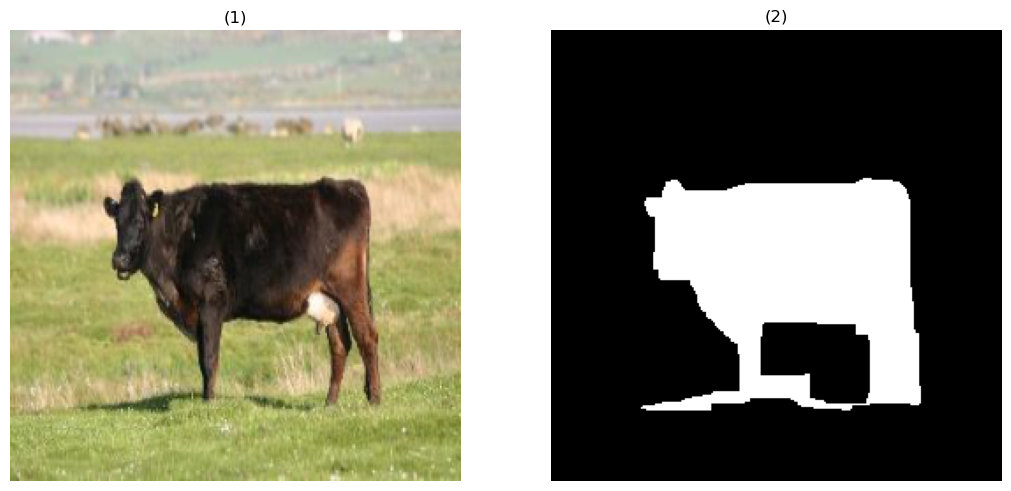

In [3]:
print(cow_resized_orig.shape)
if np.isin(1,binary_mask[:,:,2]):
    print("found")
if binary_mask[:,:,1].all()==binary_mask[:,:,2].all(): 
    print("same channel")
show_images([cow_resized_orig,binary_mask])

In [4]:
def MSD(target_patch, exemplar_patch, M_bar):
    msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
    return msd

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch=None
    min_combined_error= float('inf')
    for current_patch,other_patch in zip(target_patch,exemplar_patches):
        current_error=MSD(current_patch,other_patch,M_bar)+ SMD(current_patch,other_patch,binary_mask,M_bar)
        if current_error < min_combined_error:
            best_patch = other_patch
    return best_patch

def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [5]:
def main(img,binary_mask):
    patch_size = 8
    img_in_patches= [img[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0],patch_size) for j in range(0,img.shape[1],patch_size) ]
    full_binary_mask_patches = [binary_mask[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0],patch_size) for j in range(0,img.shape[1],patch_size) ]
    #if the patch contains a single 1 then it's subset of the target patch so mark it with 1 in the bit map
    # bit_map=[ 1 if np.isin(1,full_binary_mask_patches[i]) else 0 for i in range(len(full_binary_mask_patches))]

    target_indices=[]
    exemplar_indices=[]
    binary_mask_patches= []
    target_patches=[]
    exemplar_patches=[]
    for i, binary_mask_patch in enumerate(full_binary_mask_patches):
        start_row = ( i // img.shape[0] // patch_size) * patch_size
        start_col = ( i % (img.shape[1] // patch_size)) * patch_size
        if np.isin(1,binary_mask_patch):
            # This means that it is a target patch
            target_indices.append((i,start_row,start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            # binary_mask_patches.append(binary_mask[start_row:start_row+patch_size])

        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])


    # M_bar_patches=[np.where((binary_mask_patches[i]==0)|(binary_mask_patches[i]==1), binary_mask_patches[i]^1, binary_mask_patches) for i in range(len(binary_mask_patches))]
    M_bar_patches=[1-binary_mask_patches[i] for i in range(len(binary_mask_patches))]
    #TO-DO: call implemented functions
    new_target_patches=findBestFullPatch(target_patches,exemplar_patches,binary_mask_patches,M_bar_patches)

    new_img= np.copy(img)
    for target_index, start_row, start_col in target_indices:
        new_img[start_row: start_row+patch_size, start_col:start_col+patch_size]=new_target_patches[target_index]
    
    return new_img

    # list of tuples (i,start_row,start_col)
    '''
    for target_index, start_row, start_col in target_indices:
        img[start_row:start_row+patch_size , start_col: start_col+patch_size]=cp_target_patches[target_index]
        start_row = (i // (img.shape[0] // patch_size)) * patch_size
        start_col = (i % (img.shape[1] // patch_size)) * patch_size
    
    '''




In [6]:
grayLevelImg = rgb2gray(cow_resized_orig)
newImg= main(grayLevelImg,binary_mask[:,:,0])
show_images([newImg])

C:\Users\Habiba ElHussieny\AppData\Local\Temp\ipykernel_4540\2647441226.py:2: RuntimeWarning: invalid value encountered in scalar divide
  msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
C:\Users\Habiba ElHussieny\AppData\Local\Temp\ipykernel_4540\2647441226.py:6: RuntimeWarning: invalid value encountered in scalar divide
  target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)


TypeError: 'NoneType' object is not subscriptable